In [1]:
import cv2
import requests
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFilter
from facenet_pytorch import MTCNN
import os
import random
import torchvision.transforms as transforms
import time

img_size = 64

#Very hacky fix to make matplotlib work on my pc
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

In [2]:
# base_dir = "/home/fsuser/" # install git repo in this directory
base_dir = "c:/Users/James/git/"
repo_dir = base_dir + "de-identification/"
data_path = repo_dir+"downloaded-data/"

if not os.path.exists(data_path): 
    print("Creating folder: ", data_path)
    os.mkdir(data_path)
image_filenames = os.listdir(repo_dir)
print(image_filenames)

# Download images
# vin1234/count-the-number-of-faces-present-in-an-image

images_dir = data_path + 'num-faces/train/image_data/'

['.git', '.gitignore', 'dev-notebooks', 'downloaded-data', 'pretrained-models', 'README.md']


In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))
mtcnn = MTCNN(keep_all=True, device=device)

Running on device: cpu


In [4]:
image_filenames = list(sorted(os.listdir(images_dir))) # reserve 30 for testing
print(image_filenames[:5])

image_filenames = image_filenames[50:]
random.shuffle(image_filenames)
len(image_filenames), image_filenames[:5]

['10001.jpg', '10002.jpg', '10003.jpg', '10004.jpg', '10005.jpg']


(8146, ['10057.jpg', '15143.jpg', '14264.jpg', '17132.jpg', '16430.jpg'])

10057.jpg


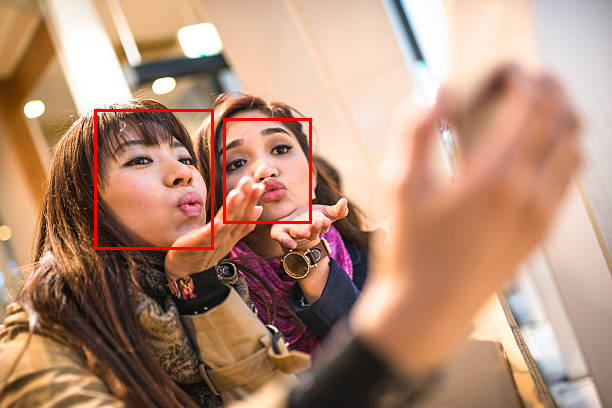

15143.jpg


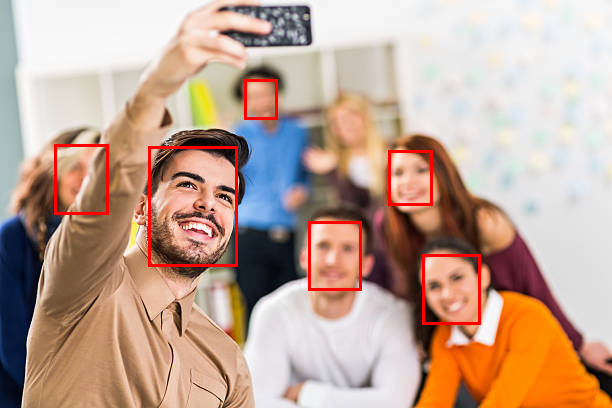

In [5]:
small_images_ignored = 0

def generate_boxes(img, threshold=0.7):
    global small_images_ignored

    all_boxes, probs, landmarks = mtcnn.detect(img.copy(), landmarks=True)
    if all_boxes is None: return []
    all_boxes = [[int(x) for x in box] for box in all_boxes] 
    #gives box values outside of image, e.g. [-6, 135, 69, 229],
    all_boxes = [[max(0, box[0]), max(0, box[1]), box[2], box[3]] for box in all_boxes]
    boxes = []
    for box, prob in zip(all_boxes, probs):
        width = box[2] - box[0]
        height = box[3] - box[1]
        #minimum requirement??
        if prob >= threshold:
            if width > 30 and height > 30:
                boxes.append(box)
            else:
                small_images_ignored+=1
    return boxes

def draw_boxes(img, boxes):
    frame_draw = img.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        draw.rectangle(box, outline=(255, 0, 0), width=3) # box = (x1, y1, x2, y2)
    return frame_draw

for image_filename in image_filenames[:2]:
    print(image_filename)
    image_path = images_dir + image_filename
    img = Image.open(image_path)
    boxes = generate_boxes(img)
    display(draw_boxes(img, boxes))
    # display(img)

In [6]:
face_num = 0
save_filepath = data_path+'face-dataset/'
t_start = time.time()
for i, image_filename in enumerate(image_filenames):
    if i % 100 == 0: print(f"{i}/{len(image_filenames)}: {time.time()-t_start:.2f} seconds | ignored: {small_images_ignored}")
    try:
        image_path = images_dir + image_filename
        img = Image.open(image_path)
        boxes = generate_boxes(img)
        # display(draw_boxes(img, boxes))
        np_img = np.array(img)
        for box in boxes:
            x1, y1, x2, y2 = box
            face = np_img[y1:y2, x1:x2]
            face_num += 1
            img_name = f"face-{face_num}-{image_filename}.jpg"
            pil_image = Image.fromarray(face)
            pil_image.save(save_filepath+img_name)
            
    except Exception as e:
        print("Exception on image: ", image_filename)

print(f"images ignored due to small size: {small_images_ignored}")

0/8146: 0.00 seconds | ignored: 1
100/8146: 28.73 seconds | ignored: 51
Exception on image:  16940.jpg
200/8146: 56.58 seconds | ignored: 108
300/8146: 83.22 seconds | ignored: 186
400/8146: 110.25 seconds | ignored: 253
500/8146: 136.59 seconds | ignored: 305
600/8146: 163.17 seconds | ignored: 348
700/8146: 190.46 seconds | ignored: 408
800/8146: 217.87 seconds | ignored: 469
900/8146: 244.33 seconds | ignored: 531
1000/8146: 270.46 seconds | ignored: 587
1100/8146: 296.57 seconds | ignored: 676
1200/8146: 321.64 seconds | ignored: 745
1300/8146: 348.63 seconds | ignored: 853
1400/8146: 374.97 seconds | ignored: 911
1500/8146: 401.52 seconds | ignored: 1024
Exception on image:  16668.jpg
1600/8146: 427.04 seconds | ignored: 1092
1700/8146: 452.89 seconds | ignored: 1167
1800/8146: 478.66 seconds | ignored: 1264
1900/8146: 504.04 seconds | ignored: 1298
2000/8146: 530.37 seconds | ignored: 1369
2100/8146: 556.96 seconds | ignored: 1459
2200/8146: 582.70 seconds | ignored: 1498
2300/81

In [50]:
dataroot = data_path + 'face-dataset/'
dataroot

'c:/Users/James/git/de-identification/downloaded-data/face-dataset/'

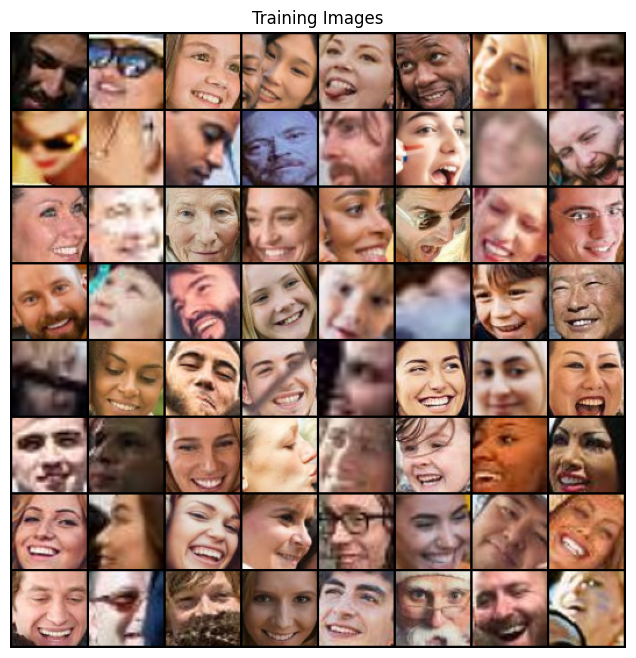

In [123]:
import torchvision.datasets as dset
import torchvision.utils as vutils
image_size = 64
border_factor = 1/8
workers = 1
batch_size = 64


dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

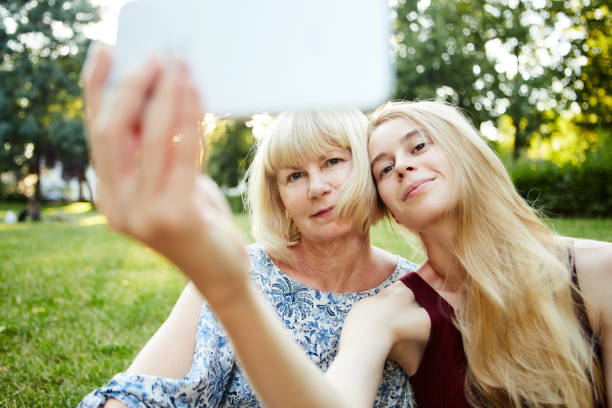

In [40]:
image_path = images_dir + image_filename
img = Image.open(image_path)
display(img)

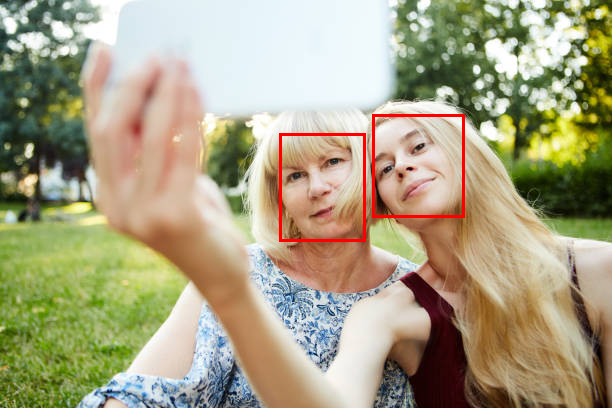

In [54]:
boxes = generate_boxes(img)
display(draw_boxes(img, boxes))

In [93]:
def crop_face(face, x, y):
    """Turns image into a square by cropping"""
    height, width, _ = face.shape
    print(height, width)
    if height > width:
        diff = height - width
        top_crop = diff // 2
        bottom_crop = diff - top_crop
        face = face[top_crop:-bottom_crop, :]
        y+=top_crop
    elif width > height:
        diff = width - height
        left_crop = diff // 2
        right_crop = diff - left_crop
        face = face[:, left_crop:-right_crop]
        x+=left_crop

    assert face.shape[0] == face.shape[1], "Face is not square"
    return face, x, y

103 92


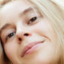

108 86


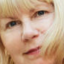

In [124]:
img_transforms = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Resize(img_size, antialias=True)])

squares = []
masks = []

np_img = np.array(img)
for box in boxes:
    x1, y1, x2, y2 = box
    face = np_img[y1:y2, x1:x2]
    square_face, x, y = crop_face(face, x1, y1)
    square_size = square_face.shape[0]
    squares.append([x, y, x+square_size, y+square_size, (0, 255, 0)])
    border = int(square_size * border_factor)
    masks.append([x+border, y+border, x+square_size-border, y+square_size-border])
    
    transformed_face = img_transforms(square_face)
    display(Image.fromarray((transformed_face*255).permute(1, 2, 0).numpy().astype(np.uint8)))

In [125]:
def draw_boxes(img, boxes, masks=None):
    frame_draw = img.copy()
    draw = ImageDraw.Draw(frame_draw)
    for box in boxes:
        colour = (255, 0, 0) if len(box) == 4 else box[4]
        draw.rectangle(box[:4], outline=colour, width=3) # box = (x1, y1, x2, y2)

    if masks is not None:
        for mask in masks:
            draw.rectangle(mask[:4], fill=(255,255,255))
    return frame_draw

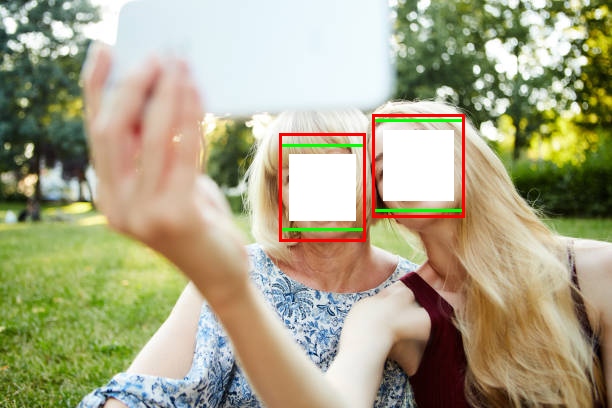

In [127]:
draw_boxes(img, squares + boxes, masks=masks)

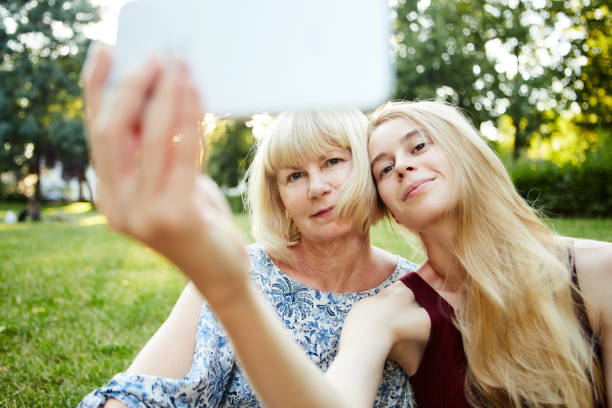

<function IPython.core.display_functions.display(*objs, include=None, exclude=None, metadata=None, transient=None, display_id=None, raw=False, clear=False, **kwargs)>

In [128]:
display(Image.fromarray(np_img))
display

(408, 612, 3)